In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_DB = os.getenv("POSTGRES_DB")

DB_HOST = "localhost"
DB_PORT = "5432"

DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{DB_HOST}:{DB_PORT}/{POSTGRES_DB}"

In [3]:
def get_db_engine():
    return create_engine(DATABASE_URL)

def fetch_data(engine):
    sql_query = """
    SELECT
        a.symbol,
        md.time,
        md.open,
        md.high,
        md.low,
        md.close,
        md.volume
    FROM market_data md
    JOIN assets a ON md.asset_id = a.id
    ORDER BY a.symbol, md.time;
    """
    print("Fetching data from the database...")
    df = pd.read_sql(sql_query, engine)
    df['time'] = pd.to_datetime(df['time'], utc=True)
    return df

def perform_eda(df):
    print("\n--- Initial Data Inspection ---")
    print(df.head())
    print("\n--- Data Information ---")
    df.info()
    print("\n--- Missing Values Check ---")
    print(df.isnull().sum())
    print("\n--- Summary Statistics ---")
    print(df.describe())

def plot_closing_prices(df):
    # Select the top 4 assets by total volume for plotting
    top_assets = df.groupby('symbol')['volume'].sum().nlargest(4).index.tolist()
    
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    print("\nPlotting closing prices for top 4 assets...")

    for i, symbol in enumerate(top_assets):
        asset_df = df[df['symbol'] == symbol]
        axes[i].plot(asset_df['time'], asset_df['close'], label=f'{symbol} Close Price', linewidth=1.5)
        axes[i].set_title(f'Closing Price for {symbol}', fontsize=14)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].set_ylabel('Price (USD)', fontsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.6)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Time Series of Closing Prices for Top Assets', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plot_file = 'closing_prices_eda.png'
    plt.savefig(plot_file)
    print(f"\nPlot saved to {plot_file}")

Fetching data from the database...

--- Initial Data Inspection ---
  symbol                      time        open        high         low  \
0   AAPL 2020-11-23 05:00:00+00:00  114.069151  114.497472  110.730209   
1   AAPL 2020-11-24 05:00:00+00:00  110.885951  112.774443  109.600987   
2   AAPL 2020-11-25 05:00:00+00:00  112.482408  113.650548  112.112492   
3   AAPL 2020-11-27 05:00:00+00:00  113.475346  114.370921  113.134639   
4   AAPL 2020-11-30 05:00:00+00:00  113.864713  117.758522  113.708957   

        close     volume  
0  110.827553  127959300  
1  112.112495  113874200  
2  112.949661   76499200  
3  113.494812   46691300  
4  115.889496  169410200  

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14958 entries, 0 to 14957
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   symbol  14958 non-null  object             
 1   time    14958 non-null  datetime64[ns, 

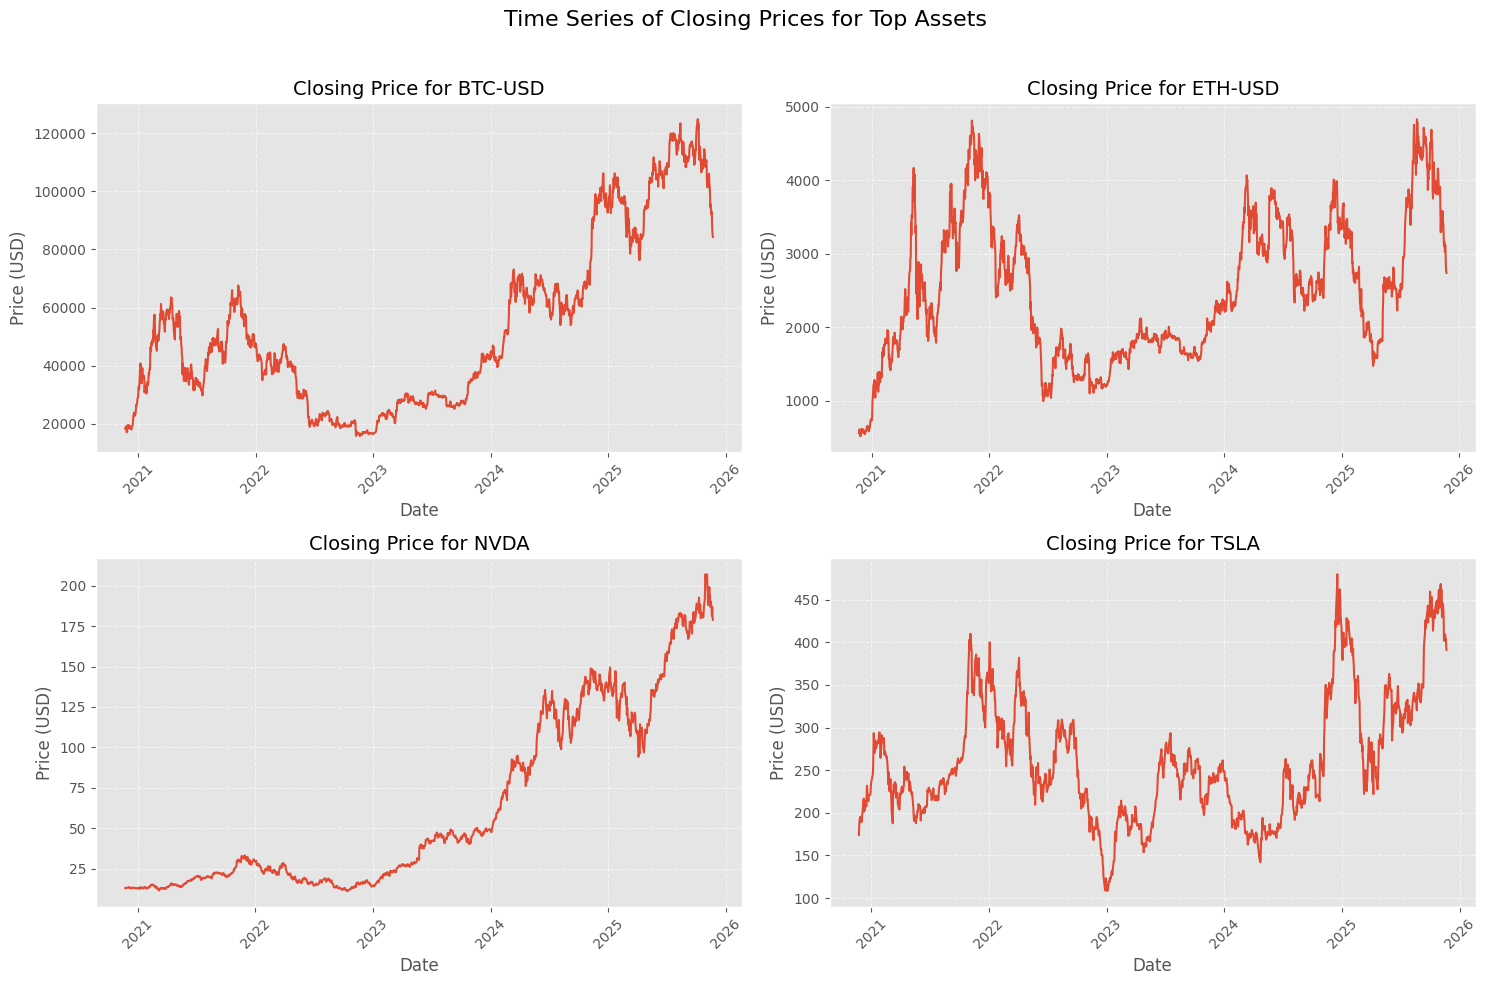

In [6]:
try:
    engine = get_db_engine()
    data_df = fetch_data(engine)

    if data_df.empty:
        print("No data retrieved. Please ensure the 'market_data' table has been populated.")
    else:
        perform_eda(data_df)
        plot_closing_prices(data_df)
except Exception as e:
    print(f"An error occurred during EDA: {e}")
    print("Please ensure your database container is running and your .env file is configured correctly.")